In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import h5py

In [3]:
#-------------------------------------
#-- Read in data and template
#-------------------------------------
fs = 4096
dataFile = h5py.File('data_w_signal.hdf5', 'r')
data = dataFile['strain/Strain'][...]
dataFile.close()
time = np.arange(0, 16, 1./fs)

templateFile = h5py.File('template.hdf5', 'r')
template = templateFile['strain/Strain'][...]
temp_time = np.arange(0, template.size / (1.0*fs), 1./fs)
templateFile.close()

Text(0.5, 1.0, 'Template')

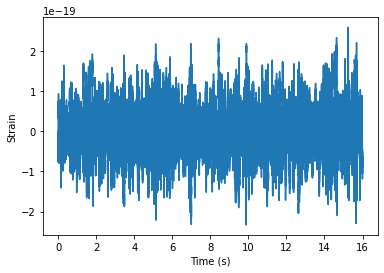

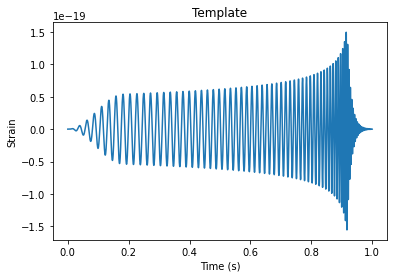

In [4]:
#------------------------
# Plot data and template
#------------------------
plt.figure()
plt.plot(time,data)
plt.xlabel('Time (s)')
plt.ylabel('Strain')

plt.figure()
plt.plot(temp_time, template)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.title('Template')

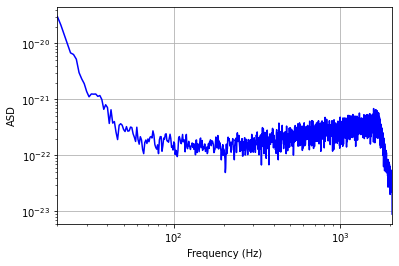

In [5]:
#------------------------
# Plot ASD of data
#-----------------------
plt.figure()
power_data, freq_psd = plt.psd(data[12*fs:], Fs=fs, NFFT=fs, visible=False)
plt.close()
plt.figure()
plt.loglog(freq_psd, np.sqrt(power_data), 'b')
plt.xlim([20, 2048])
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD')
plt.grid('on')

<ipython-input-6-37ce388afec3>:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.loglog(freq, np.sqrt(power), 'r')


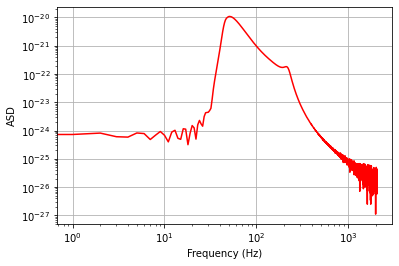

In [6]:
#----------------------
# Plot ASD of template
#----------------------
power, freq = plt.psd(template, Fs=fs, NFFT=fs, visible=False)
plt.loglog(freq, np.sqrt(power), 'r')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD')
plt.grid('on')


Text(0.5, 0, 'Time (s)')

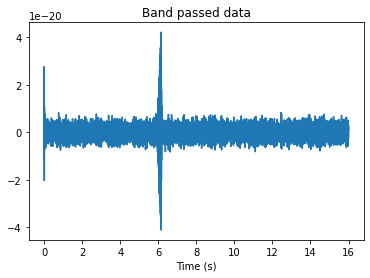

In [7]:
#-------------------------------------
# Apply a bandpass filter to the data
#------------------------------------
(B,A) = sig.butter(4, [80/(fs/2.0), 250/(fs/2.0)], btype='pass')
data_pass= sig.lfilter(B, A, data)
plt.figure()
plt.plot(time, data_pass)
plt.title('Band passed data')
plt.xlabel('Time (s)')

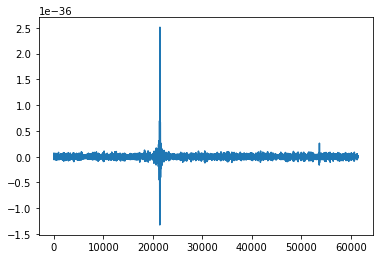

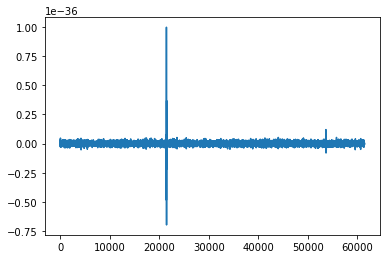

In [9]:
correlated_raw = np.correlate(data, template, 'valid')
correlated_passed = np.correlate(data_pass, template, 'valid')
plt.figure()
plt.plot(correlated_raw)
plt.figure()
plt.plot(correlated_passed)

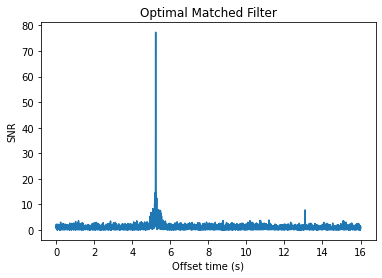

In [8]:
#------------------------------
# Optimal Filter, freq. domain
#------------------------------
#-- Take the FFT of the data
data_fft=np.fft.fft(data)

#--- Pad template and take FFT (sometimes instead of padding people will just window both data and template)
zero_pad = np.zeros(data.size - template.size)
template_padded = np.append(template, zero_pad)
template_fft = np.fft.fft(template_padded)

# Next, we need an estimate of the noise power in each FFT bin. We take the PSD of the last 4 seconds
# Assuming there's no signal there and just noise
# The numpy FFT returns and array with a particular convention for the order of frequency bins, so we need to interpolate
# the PSD to estimate values at each FFT frequency

# --- Match FFT frequency bins to PSD frequency bins
datafreq = np.fft.fftfreq(data.size)*fs
power_vec = np.interp(datafreq, freq_psd, power_data)

# -- Calculate the matched filter:
# Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
# Taking the Inverse Fourier Transform (IFFT) of the filter output puts it back in the time domain,
# so the result will be plotted as a function of time off-set between the template and the data:
optimal = data_fft * template_fft.conjugate() / power_vec
optimal_time = 2*np.fft.ifft(optimal)

# -- Normalize the matched filter output
df = np.abs(datafreq[1] - datafreq[0])
sigmasq = 2*(template_fft * template_fft.conjugate() / power_vec).sum() * df
sigma = np.sqrt(np.abs(sigmasq))
SNR = abs(optimal_time) / (sigma)

#To find the exact time you could maximize a SNR array perhaps
# -- Plot the result
plt.figure()
plt.plot(time, SNR)
plt.title('Optimal Matched Filter')
plt.xlabel('Offset time (s)')
plt.ylabel('SNR')
plt.show()